# Foreigner Crime and Electoral Success of Extremists in the 2019-EU Elections in Germany
#### Purpose: 
This analysis tries to shed some light on the most recent electoral success of the right wing party Alternative für Deutschlandschland (AfD) in the EU parlamentary elections 2019. It compares the change of 2019 and 2014 AfD vote share with the number of foreign suspects for a set of about 40 crimes across 400 regions in Germany. Is there a positive correlation between crime (presumably) committed by foreigners and AfDs electoral success?
#### Motivation: 
AfD officials have repeatedly denounced migrants being responsible for a surge in crime rates. Consequently, the German Federal Criminal Police Office (BKA) has analyzed the claim and demonstrated this being a consequence of the age and sex structure of the recent migratory wave. The migrants are predominantly male and young. Independently of their origin this is a social group that has an comparatively huge propensity to commit crime. 
Still, most migrants that is foreigners are not living in the regions where AfD has had their biggest success, particularly Eastern German states. 
Here, I want to find out if it has been rather the fear of crime rather than crime itself that made voters elect AfD.
#### Data:
The visual analysis is based on two data sets on a regional level. There are 400 of those regions, that is, cities that are independent of any region, in Germany. They have a name and an official regional code. The first 2 digits of the code indicate the states (there are 16 of them in Germany, including the city-states Berlin, Hamburg and Bremen). The two datasets are:
1. The election results data downloaded here https://www.bundeswahlleiter.de/europawahlen/2019/ergebnisse.html (last accessed 2019-07-27). 
2. Data on crime committed by foreigners in Germany, retrieved from https://www.bka.de/DE/Home/home_node.html (last retrieved 2019-08-07). The data and preperation of the data are explained in more detail in the yupiter-notebook bka_crime_foreigners.


In [95]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as stats
import re
from sklearn.linear_model import LinearRegression

## Results of the most recent European Elections in Germany (2019). 
Source: https://www.bundeswahlleiter.de/europawahlen/2019/ergebnisse.html (last accessed 2019-07-27).

Contains results for all cities and free regions for all 16 German Laender and aggregated Data for Laender. 

In [3]:
EuElect = pd.read_csv('ew19_kerg.csv',sep=';',skiprows=[0],header=[1])#,index_col=-1)
EuElect = EuElect[EuElect.isnull().Nr==False]
EuElect.set_index('Nr',inplace=True)
EuElect.head()

,Gebiet,gehört zu,Wahlberechtigte,Unnamed: 4,Wähler/-innen,Unnamed: 6,Ungültige,Unnamed: 8,Gültige,Unnamed: 10,...,Unnamed: 86,PARTEI FÜR DIE TIERE DEUTSCHLAND,Unnamed: 88,Partei für Gesundheitsforschung,Unnamed: 90,Volt Deutschland,Unnamed: 92,Übrige,Unnamed: 94,Unnamed: 95
Nr,,,,,,,,,,,,,,,,,,,,,
1001.0,"Flensburg, Stadt",1.0,70431,70929,39647,25350,237,176,39410,25174,...,NaN,61,NaN,47,NaN,285,NaN,NaN,160,NaN
1002.0,"Kiel, Landeshauptstadt",1.0,186195,188135,109595,75741,577,405,109018,75336,...,NaN,144,NaN,129,NaN,1139,NaN,NaN,283,NaN
1003.0,"Lübeck, Hansestadt",1.0,166530,167198,90946,62933,461,424,90485,62509,...,NaN,126,NaN,104,NaN,935,NaN,NaN,256,NaN
1004.0,"Neumünster, Stadt",1.0,60215,60970,29036,27659,231,409,28805,27250,...,NaN,56,NaN,34,NaN,114,NaN,NaN,185,NaN
1051.0,Dithmarschen,1.0,107045,107804,58244,42819,475,469,57769,42350,...,NaN,118,NaN,111,NaN,185,NaN,NaN,168,NaN


In [4]:
# Getting AfD 2019 and 2014
AfD_colname=list(EuElect.columns.str.contains('Alternative'))
AfD_colind = np.where(AfD_colname)[0][0]
election = EuElect.iloc[:, [a for a in np.arange(10)]+[AfD_colind, AfD_colind+1]]
# columns in English
election.columns = ['region'
              , 'subregion'
              , 'eligible_voters_19'
              , 'eligible_voters_14'
              , 'voters_19'
              , 'voters_14'
              , 'invalid_19'
              , 'invalid_14'
              , 'valid_19'
              , 'valid_14'
              , 'afd_19'
              , 'afd_14']
# creating a common index for merge later on
election.index = [str(int(a)) for a in election.index]

election.to_csv('election_aux.csv', sep=';',decimal=',',encoding='utf-8')
election = pd.read_csv('election_aux.csv', sep=';', decimal=',')#,index_col=0)
election.rename(columns={'Unnamed: 0':'region_key'}, inplace = True)
election.head()


,region_key,region,subregion,eligible_voters_19,eligible_voters_14,voters_19,voters_14,invalid_19,invalid_14,valid_19,valid_14,afd_19,afd_14
0,1001,"Flensburg, Stadt",1.0,70431,70929,39647,25350,237,176,39410,25174,2477,1583
1,1002,"Kiel, Landeshauptstadt",1.0,186195,188135,109595,75741,577,405,109018,75336,6459,4418
2,1003,"Lübeck, Hansestadt",1.0,166530,167198,90946,62933,461,424,90485,62509,6773,4334
3,1004,"Neumünster, Stadt",1.0,60215,60970,29036,27659,231,409,28805,27250,2761,1960
4,1051,Dithmarschen,1.0,107045,107804,58244,42819,475,469,57769,42350,5121,2325


### Adding some columns
- relative share of votes for AfD per voters 19 and 14(afd_vot19 and afd_vot14)
- relative share of votes for AfD per eligable_voters (afd_eli19)
- relative share of votes for Afd per valid votes cast (afd_val19)
- change in share of overindebted adults from 2013 to 2018 in % (ove18_13)
- change in share of AfD between 19 and 14 (vot19_14)

In [5]:
election['afd_vot19']= election.afd_19 / election.voters_19*100
election['afd_eli19']= election.afd_19 / election.eligible_voters_19*100
# Thats the statistic reported on, as it reflects outcome
election['afd_val19']= election.afd_19 / election.valid_19*100
election['afd_val14']= election.afd_14 / election.valid_14*100
election['vot19_14']=election.afd_val19-election.afd_val14
election['part']='blue'
election.loc[election['subregion']>=12,'part']='red'
election.tail()

,region_key,region,subregion,eligible_voters_19,eligible_voters_14,voters_19,voters_14,invalid_19,invalid_14,valid_19,valid_14,afd_19,afd_14,afd_vot19,afd_eli19,afd_val19,afd_val14,vot19_14,part
413,16075,Saale-Orla-Kreis,16.0,67029,71195,42514,38529,884,1181,41630,37348,11264,3114,26.494802,16.804667,27.057411,8.337796,18.719615,red
414,16076,Greiz,16.0,82940,88102,53197,48740,1139,1551,52058,47189,13297,4559,24.995770,16.032071,25.542664,9.661150,15.881514,red
415,16077,Altenburger Land,16.0,75936,80935,42954,39093,1053,1436,41901,37657,11371,3023,26.472505,14.974452,27.137777,8.027724,19.110053,red
416,16,Thüringen,99.0,1740866,1821933,1071240,940373,21019,26096,1050221,914277,236579,68011,22.084594,13.589731,22.526592,7.438774,15.087818,red
417,99,Bundesgebiet,NaN,61600263,61998824,37807746,29843798,410857,488706,37396889,29355092,4104453,2070014,10.856117,6.663045,10.975386,7.051635,3.923751,blue


# Crime data
#### Description
The data provided by the German Federal Criminal Police Office (BKA). 
The data are taken from Table 50 covering "Kreise und kreisfreie Städte" (Regions and independent cities) 
of the annual publications of BKA for the years 2014 to 2018. The 2013 data set was not available. The data 
were retrieved 2019-08-07 from the Pol https://www.bka.de/DE/AktuelleInformationen/StatistikenLagebilder/PolizeilicheKriminalstatistik/pks_node.html. 
- 2018: https://www.bka.de/SharedDocs/Downloads/DE/Publikationen/PolizeilicheKriminalstatistik/2018/BKATabellen/TatverdaechtigeLaenderKreiseStaedte/BKA-LKS-TV-11-T50-Kreise-TV-nichtdeutsch_excel.xlsx?__blob=publicationFile&v=3
- 2017: https://www.bka.de/SharedDocs/Downloads/DE/Publikationen/PolizeilicheKriminalstatistik/2017/BKATabellen/TatverdaechtigeLaenderKreiseStaedte/BKA-LKS-TV-11-T50-Kreise-TV-nichtdeutsch_excel.xlsx?__blob=publicationFile&v=3
- 2016: https://www.bka.de/SharedDocs/Downloads/DE/Publikationen/PolizeilicheKriminalstatistik/2016/BKATabellen/TatverdaechtigeLaenderKreiseStaedte/BKA-LKS-TV-11-T50-Kreise-TV-nichtdeutsch_excel.xlsx?__blob=publicationFile&v=3
- 2015: https://www.bka.de/SharedDocs/Downloads/DE/Publikationen/PolizeilicheKriminalstatistik/2015/BKATabellen/TatverdaechtigeLaenderKreiseStaedte/tb50_TatverdaechtigeNichtdeutschAlterKreise_excel.xlsx?__blob=publicationFile&v=3
- 2014: https://www.bka.de/SharedDocs/Downloads/DE/Publikationen/PolizeilicheKriminalstatistik/2014/BKATabellen/TatverdaechtigeLaenderKreiseStaedte/tb50_TatverdaechtigeNichtdeutschAlterLaender_excel.xlsx?__blob=publicationFile&v=2


In [ ]:

bka14 = pd.read_excel('2014tb50_TatverdaechtigeNichtdeutschAlterKreise_excel.xlsx', skip=[0,1,2,3,4,5,6,7,8],header=8)
bka14 = bka14[bka14.iloc[:,4]=='X']
bka14 = bka14.iloc[:,[0,1,2,3,5]]
bka14.columns = ['crime_key', 'crime', 'region_key', 'region', 'NSuspects14']
bka14.head()

def osterodeGoettingen(bka, target):
    '''
    2014, 2015 and 2016 two regions Göttingen and Osterode am Harz need to be merged 
    as from 2017 the region has been united as Oettingen
    '''
    osterode = bka[bka.region=='Osterode am Harz']
    for key in osterode.crime_key:
        oster_val = osterode.loc[osterode.crime_key==key,target].values[0]
        #print(oster_val)
        goett_val = bka.loc[(bka.crime_key==key)&(bka.region=='Göttingen'),target].values[0]
        #print(goett_val)
        bka.loc[(bka.crime_key==key)&(bka.region=='Göttingen'),target] = oster_val+goett_val
        #print(oster_val+goett_val)
    bka = bka[bka.region!='Osterode am Harz']
    bka.loc[bka.region=='Göttingen','region_key'] = 3159
    return bka

bka14 = osterodeGoettingen(bka14, 'NSuspects14')

bka15 = pd.read_excel('2015tb50_TatverdaechtigeNichtdeutschAlterKreise_excel.xlsx', skip=[0,1,2,3,4,5,6,7,8],header=8)
bka15 = bka15[bka15.iloc[:,5]=='X']
bka15 = bka15.iloc[:,[0,1,2,3,6]]
bka15.columns = ['crime_key', 'crime', 'region_key', 'region', 'NSuspects15']
bka15 = osterodeGoettingen(bka15, 'NSuspects15')

bka16 = pd.read_excel('2016tb50_TatverdaechtigeNichtdeutschAlterKreise_excel.xlsx', skip=[0,1,2,3,4,5,6,7,8],header=8)
bka16 = bka16[bka16.iloc[:,5]=='X']
bka16 = bka16.iloc[:,[0,1,2,3,6]]
bka16.columns = ['crime_key', 'crime', 'region_key', 'region', 'NSuspects16']
bka16 = osterodeGoettingen(bka16, 'NSuspects16')
bka16.head()
bka16.shape

bka17 = pd.read_excel('2017tb50_TatverdaechtigeNichtdeutschAlterKreise_excel.xlsx', 
                      skip=[0,1,2,3,4,5,6,7,8],header=8, usecols = [0,1,2,3,4,5,6])
bka17 = bka17[bka17.iloc[:,5]=='X']
bka17 = bka17.iloc[:,[0,1,2,3,6]]
bka17.columns = ['crime_key', 'crime', 'region_key', 'region', 'NSuspects17']

bka18 = pd.read_excel('2018tb50_TatverdaechtigeNichtdeutschAlterKreise_excel.xlsx', 
                      skip=[0,1,2,3,4,5,6,7,8],header=8, usecols = [0,1,2,3,4,5,6])
bka18 = bka18[bka18.iloc[:,5]=='X']
bka18 = bka18.iloc[:,[0,1,2,3,6]]
bka18.columns = ['crime_key', 'crime', 'region_key', 'region', 'NSuspects18']

bka18.head()

bka = bka14.merge(bka15
                  ,left_on=['crime_key', 'crime', 'region_key', 'region'], 
                  right_on=['crime_key', 'crime', 'region_key', 'region'],
                 how='left', indicator=True)
# in 2015 there are additional rows for crimes without crimes against asylum laws

# eliminating indicator columns for new merger
bka = bka.iloc[:,[0,1,2,3,4,5]]

bka = bka.merge(bka16
                  ,left_on=['crime_key', 'crime', 'region_key', 'region'], 
                  right_on=['crime_key', 'crime', 'region_key', 'region'],
                 how='outer')#, indicator=True)

# eliminating indicator columns for new merger
bka = bka.iloc[:,[0,1,2,3,4,5,6]]

bka = bka.merge(bka17
                  ,left_on=['crime_key', 'crime', 'region_key', 'region'], 
                  right_on=['crime_key', 'crime', 'region_key', 'region'],
                 how='outer')#, indicator=True)

bka = bka.merge(bka18
                  ,left_on=['crime_key', 'crime', 'region_key', 'region'], 
                  right_on=['crime_key', 'crime', 'region_key', 'region'],
                 how='outer')#, indicator=True)

# write csv for translation and relabelling. Due to changes in criminal law the German 
# labels have been changing over time, e.g., some paragraphs extending the definition of 
# criminal law covering sexual violance.
(bka.groupby('crime').agg(np.sum)).to_excel('labels_ueber_zeit.xlsx')

# read translations and regrouped labels back in
labels_new = pd.read_excel('labels_translation.xlsx')
labels_new.head()

# mapping them into the dataframe
bka['crime_eng']=bka['crime'].map(dict(zip(labels_new.crime, labels_new.english_label)))

bka = bka.groupby(['region', 'crime_eng']).agg(np.sum)
bka.reset_index(inplace=True)
# getting regional key back
bka.merge(bka14.iloc[:,[2,3]], left_on='region',right_on='region')


One of the most important columns, foreign suspects without considering crimes committed against migrational laws 
is only reported by BKA for 2016, 2017 and 2018. It needs to be calculated manually here.

aux_total1415 = bka.loc[bka['crime_eng']=='total',['NSuspects14','NSuspects15']]
aux_asylum1415 = bka.loc[bka['crime_eng']=='asylum_free_movement',['NSuspects14','NSuspects15']]
aux_total_minus_asysum1415 = aux_total1415.values - aux_asylum1415.values
bka.loc[bka['crime_eng']=='without_asylum',['NSuspects14','NSuspects15']] = aux_total_minus_asysum1415

# computing change rates year-on-year
bka['cr_chg_15'] = (bka.NSuspects15-bka.NSuspects14)/bka.NSuspects14
bka['cr_chg_16'] = (bka.NSuspects16-bka.NSuspects14)/bka.NSuspects14
bka['cr_chg_17'] = (bka.NSuspects17-bka.NSuspects14)/bka.NSuspects14
bka['cr_chg_18'] = (bka.NSuspects18-bka.NSuspects14)/bka.NSuspects14
bka = bka[-bka.crime_eng.str.contains('cyb|_attack')]


#bka[['crime_eng','cr_chg_15', 'cr_chg_16', 'cr_chg_17', 'cr_chg_18']].groupby('crime_eng').median()
bka.head()

# recovering regional keys
bka14_aux = bka14[bka14['crime']=='Straftaten insgesamt']
bka14_aux = bka14_aux.loc[:,['region_key','region']]
bka14_aux.head()

### Preparing dataframe for export
- reshaping the dataframe to have only regions as rows
- maxima of suspects per crime per year
- maxima of change per year of total suspects


bka_new = bka[bka.crime_eng=='without_asylum']
bka_new['max_perc_chg']=bka_new[['cr_chg_15','cr_chg_16','cr_chg_17','cr_chg_18']].max(axis=1)
bka_new = bka_new.iloc[:,[0,1,11]]
bka_new = bka_new.merge(bka14_aux, left_on='region',right_on='region')
bka_new = bka_new.iloc[:,[3,0,2]]
bka_new.head()


for crime in bka.crime_eng.unique():
    #crime = bka.crime_eng[0]
    bka_aux = bka[bka.crime_eng==crime]
    bka_aux[crime]=bka_aux[['region','NSuspects14','NSuspects15','NSuspects16','NSuspects17','NSuspects18']].max(axis=1)
    bka_aux = bka_aux.loc[:,['region',crime]]
    bka_new = bka_new.merge(bka_aux)
bka_new.head()


#bka_new.to_excel('bka.xlsx')

# Merging datasets

In [235]:
df = election.merge(bka, on='region_key')
# the maxima of the bka dataset need to be set against the actual size of the respective region. 
# Therefore, each column is divided by the number of eligible voters in 2019.
# This does not hold for the region, the region_key and the max_perc_chg. The latter is the maximum percentage change of 
# suspects in each region from 2014 to 2018.
bka_cols = bka.columns[3:]
for col in bka_cols:
    df[col]=df[col]/df['eligible_voters_19']*100
df.head()
#df_aux = df[df.region_x!=df.region_y]
#df_aux[['region_x','region_y']].head()
df_final = df[['region_key', 'region_x', 'subregion', 'afd_val19','eligible_voters_19','vot19_14', 'part', 'region_y',
       'max_perc_chg', 'advantage', 'approximation', 'arson',
       'asylum_free_movement', 'computer', 'damage_property',
       'daylight_burglary', 'drug', 'embezzlement', 'forgery', 'fraud',
       'graffiti', 'housbreaking', 'immigration', 'injury_dangerous',
       'injury_simple', 'murder', 'obtaining', 'officer_resistence',
       'pickpocketing', 'robbery_finance', 'robbery_flat', 'robbery_handbag',
       'robbery_motorist', 'robbery_other', 'robbery_paying', 'sexual',
       'shoplifting', 'street_crime', 'theft_aggrevated', 'theft_bicycle',
       'theft_cars', 'theft_motor_incl_out_of', 'theft_motorcycle',
       'theft_simple', 'theft_total', 'total', 'violent_crime',
       'without_asylum']]
df_final['EastWest']=df_final.part.map({'blue':'West', 'red':'East'})
df_final = df_final[df_final.without_asylum<10]

C:\Users\dirku\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


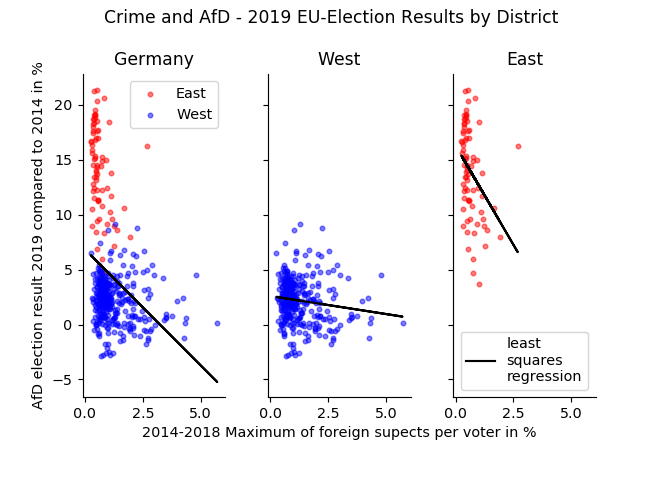

In [236]:
f, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)#, sharey=True)
#f.figsize=(9,12)
f.suptitle('Crime and AfD - 2019 EU-Election Results by District')

ax1.set_title('Germany')
plt.subplots_adjust(top=0.85,bottom=0.2)
ax2.set_title('West')

linreg = LinearRegression()
y = df_final['vot19_14'].values.reshape(-1,1)
x = df_final['without_asylum'].values.reshape(-1,1)
linreg.fit(x,y )
ypred = linreg.predict(x)
ax1.plot(x,ypred,c='black')
#ax1.legend()

#ax1.scatter( df_final.without_asylum,df_final.vot19_14, c=df_final.part)

ax1.set_ylabel('AfD election result 2019 compared to 2014 in %')
cdict = {'West':'blue', 'East':'red'}
g = 'East'
ix = df_final.EastWest==g
ax1.scatter(df_final.without_asylum[ix], df_final.vot19_14[ix], c = cdict[g], label = g, s=10, alpha=0.5)
ax1.legend()
g = 'West'
ix = df_final.EastWest==g
ax1.scatter(df_final.without_asylum[ix], df_final.vot19_14[ix], c = cdict[g], label = g, s=10, alpha=0.5)
ax1.legend()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#plt.axis('equal')

df_west = df_final[df_final.part=='blue']
ax2.set_title('West')
linreg_west = LinearRegression()
y_west = df_west['vot19_14'].values.reshape(-1,1)
x_west = df_west['without_asylum'].values.reshape(-1,1)
linreg_west.fit(x_west,y_west )
ypred_west = linreg_west.predict(x_west)
ax2.plot(x_west,ypred_west,c='black',label='regression')

ax2.scatter( df_west.without_asylum,df_west.vot19_14,  c='blue', s=10, alpha=0.5)
ax2.set_xlabel('2014-2018 Maximum of foreign supects per voter in %')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

df_east = df_final[df_final.part=='red']
ax3.set_title('East')

linreg_east = LinearRegression()
y_east = df_east['vot19_14'].values.reshape(-1,1)
x_east = df_east['without_asylum'].values.reshape(-1,1)
linreg_east.fit(x_east, y_east)
ypred_east = linreg_east.predict(x_east)
ax3.plot(x_east,ypred_east,c='black',label='least\nsquares\nregression')
ax3.legend()
ax3.scatter(df_east.without_asylum,df_east.vot19_14, c='red', s=10, alpha=0.5)#,s=df_east.eligible_voters_19/10000)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

plt.subplots_adjust(top=0.85,bottom=0.2, wspace=0.3)
plt.savefig("election_and_crime.svg", dpi=150)

### Individual crimes
Here, I check, if there is any positive correlation between ecelection results and individual crimes. There is none, except for max_change, giving the maximum change of the number of suspects per region when compared to 2014.

<IPython.core.display.Javascript object>


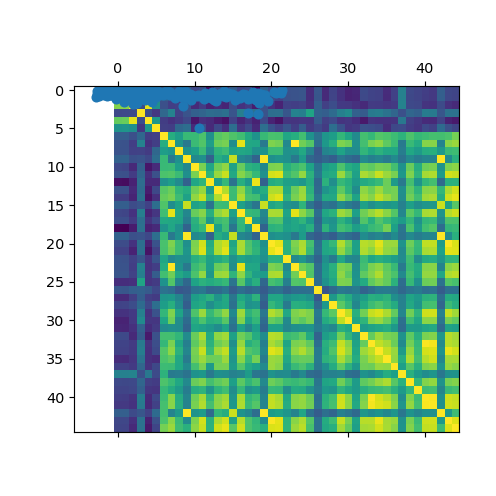

region_key                 0.665838
subregion                  0.674840
afd_val19                  0.948872
eligible_voters_19        -0.076823
vot19_14                   1.000000
max_perc_chg               0.338307
advantage                 -0.157709
approximation             -0.204646
arson                     -0.165407
asylum_free_movement      -0.106442
computer                  -0.329330
damage_property           -0.217052
daylight_burglary         -0.244431
drug                      -0.304067
embezzlement              -0.341274
forgery                   -0.141722
fraud                     -0.267845
graffiti                  -0.198839
housbreaking              -0.276865
immigration               -0.106992
injury_dangerous          -0.271677
injury_simple             -0.336955
murder                    -0.195699
obtaining                 -0.202300
officer_resistence        -0.186461
pickpocketing             -0.192392
robbery_finance           -0.005158
robbery_flat              -0

In [204]:
plt.matshow(df_final.corr())
df_final.corr()['vot19_14']


<IPython.core.display.Javascript object>


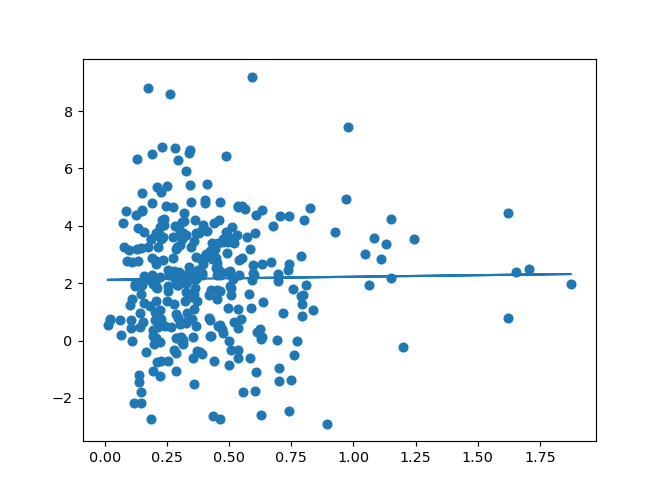

In [221]:
fig, ax = plt.subplots(1,1)

regchg_west = LinearRegression()
ychg_west = df_west.vot19_14.values.reshape(-1,1)
xchg_west = df_west.max_perc_chg.values.reshape(-1,1)
regchg_west.fit(xchg_west,ychg_west)
ychg_pred_west = regchg_west.predict(xchg_west)
ax.scatter(xchg_west,ychg_west)
ax.plot(xchg_west,ychg_pred_west)
#ax.plot(xchg_west, ychg_pred)

<IPython.core.display.Javascript object>


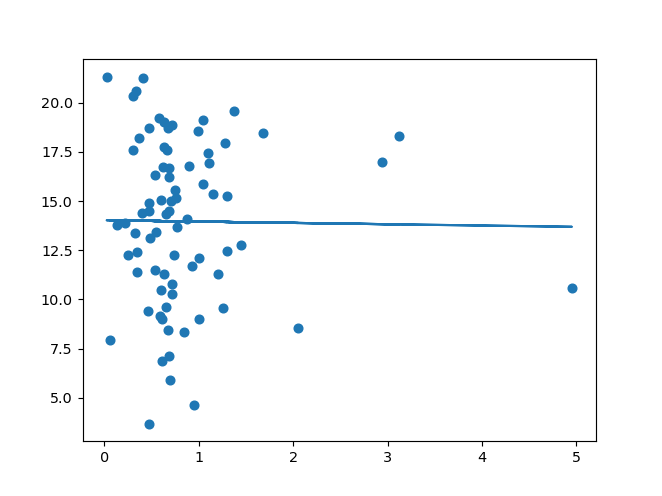

76

In [222]:
fig, ax = plt.subplots(1,1)

regchg_east = LinearRegression()
ychg_east = df_east.vot19_14.values.reshape(-1,1)
xchg_east = df_east.max_perc_chg.values.reshape(-1,1)
regchg_east.fit(xchg_east,ychg_east)
ychg_pred_east = regchg_east.predict(xchg_east)
ax.scatter(xchg_east,ychg_east)
ax.plot(xchg_east,ychg_pred_east)
len(xchg_east)